In [1]:
%load_ext lab_black

# This notebook performs the training by using the NO$_2$ average of the whole MCM, then with that trained model each single pixel is estimated.

In [2]:
# Please import here all the necessary libraries
import pandas as pd

# import io
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# plt.rcParams["figure.figsize"] = (20,7)
from math import sqrt
from tqdm import tqdm
import plotly.graph_objects as go
import os
import datacube
from scipy.stats import loguniform, uniform
from matplotlib.pyplot import figure
import geopandas as gpd
import openpyxl
import math
from itertools import combinations
import ipywidgets as widgets

# import plotly.express as px
import xarray as xr
from shapely.geometry import box
import glob
import rioxarray as rio
import rasterio

# ML
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, SplineTransformer

# import torch
# import torch.nn as nn
# from torch.autograd import Variable
from tensorflow import keras

# from keras_tuner.tuners import BayesianOptimization
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    VotingRegressor,
    StackingRegressor,
)
from sklearn.svm import SVR
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    RationalQuadratic,
    CompoundKernel,
    WhiteKernel,
)
from sklearn.neural_network import MLPRegressor

# Feature Selection
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV

import tensorflow as tf

# from tensorflow.keras import datasets, layers, models

# Hide Warnings
import warnings

warnings.filterwarnings("ignore")

# Get Data Using ODC

In [3]:
dc = datacube.Datacube(
    app="my_app", config="/Users/rodrigo/Documents/2_PoliMi/odc/datacube.conf"
)
list_of_products = dc.list_products()
list_of_products

,name,description,license,default_crs,default_resolution
name,,,,,
Sentinel5P_NO2_CDMX,Sentinel5P_NO2_CDMX,Sentinel-5P NO2 for the metropolitan area of M...,None,None,None
Sentinel5P_NO2_Milano,Sentinel5P_NO2_Milano,Sentinel-5P NO2 for the administrative area of...,None,None,None


### Mexico City Metropolitan Area

<Axes: >

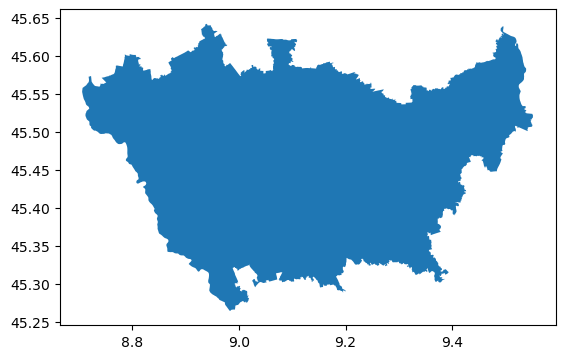

In [4]:
milano = gpd.read_file(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/shp/MCM/MCM_wgs84.shp"
)
milano = milano.to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
milano.plot()

In [5]:
milano.bounds

,minx,miny,maxx,maxy
0,8.706096,45.264994,9.551562,45.642668


### Sentinel 5P NO$_2$

In [6]:
product_S5P = "Sentinel5P_NO2_Milano"
ds_S5P = dc.load(product=product_S5P)
ds_S5P = ds_S5P.where(ds_S5P["tropospheric_NO2_column_number_density"] != -9999)
ds_S5P

<xarray.Dataset>
Dimensions:                                 (time: 2362, latitude: 24,
                                             longitude: 40)
Coordinates:
  * time                                    (time) datetime64[ns] 2019-01-01T...
  * latitude                                (latitude) float64 45.94 ... 45.02
  * longitude                               (longitude) float64 8.025 ... 9.975
    spatial_ref                             int32 4326
Data variables:
    tropospheric_NO2_column_number_density  (time, latitude, longitude) float64 ...
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

In [7]:
S5P_gdf = ds_S5P.to_dataframe()
S5P_gdf = S5P_gdf.dropna()
S5P_gdf = S5P_gdf[["tropospheric_NO2_column_number_density"]]
S5P_gdf.reset_index(drop=False, inplace=True)
S5P_gdf = gpd.GeoDataFrame(
    S5P_gdf, geometry=gpd.points_from_xy(S5P_gdf["longitude"], S5P_gdf["latitude"])
)
S5P_gdf = gpd.clip(S5P_gdf, milano.geometry)
S5P_gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
S5P_gdf["date"] = pd.to_datetime(S5P_gdf["time"], format="%Y-%m-%d %H:%M:%S")
S5P_gdf["date"] = S5P_gdf["date"].dt.strftime("%Y-%m-%d")
S5P_gdf["date"] = pd.to_datetime(S5P_gdf["date"], format="%Y-%m-%d")
S5P_gdf.sort_index(inplace=True)
S5P_gdf = S5P_gdf[["date", "tropospheric_NO2_column_number_density", "geometry"]]
S5P_gdf = S5P_gdf.rename(
    columns={"tropospheric_NO2_column_number_density": "satellite_no2"}
)
S5P_gdf.to_csv("/Volumes/Rodrigo_2TB/Milano/Dataframes/df-s5p-milano.csv")
# del S5P_gdf

S5P_gdf["date"] = pd.to_datetime(S5P_gdf["date"], format="%Y-%m-%d")
# S5P_gdf_plot = S5P_gdf[["date", "satellite_no2"]].groupby("date").mean()
# S5P_gdf_plot = S5P_gdf_plot[
#    (S5P_gdf_plot.index < "2023-01-01") & (S5P_gdf_plot.index > "2022-01-01")
# ]
# S5P_gdf_plot.reset_index(drop=False, inplace=True)
# S5P_gdf_plot.plot()

In [8]:
S5P_gdf

,date,satellite_no2,geometry
149,2019-01-01,0.000157,POINT (9.07500 45.62000)
171,2019-01-01,0.000130,POINT (8.77500 45.58000)
172,2019-01-01,0.000150,POINT (8.82500 45.58000)
173,2019-01-01,0.000150,POINT (8.87500 45.58000)
174,2019-01-01,0.000129,POINT (8.92500 45.58000)
...,...,...,...
1035366,2024-05-29,0.000050,POINT (8.92500 45.34000)
1035367,2024-05-29,0.000050,POINT (8.97500 45.34000)
1035368,2024-05-29,0.000054,POINT (9.02500 45.34000)
1035369,2024-05-29,0.000056,POINT (9.07500 45.34000)


<Axes: xlabel='date'>

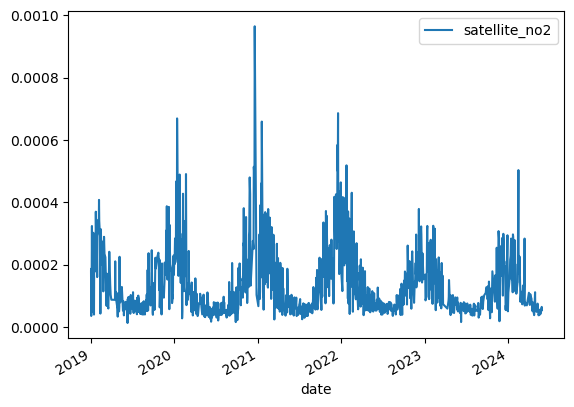

In [9]:
S5P_gdf[["date", "satellite_no2"]].groupby("date").mean().reset_index(drop=False).plot(
    x="date", y="satellite_no2"
)

# MCM Ground Sensors NO$_2$ 

In [10]:
milano_no2 = pd.read_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/arpa_no2_Milan_single_pixels.csv",
)
milano_no2 = milano_no2.rename(columns={"valore": "ground_no2", "data": "date"})
# milano_no2.reset_index(drop=True, inplace=True)
milano_no2["date"] = pd.to_datetime(milano_no2["date"], format="%Y-%m-%d")
milano_no2 = gpd.GeoDataFrame(
    milano_no2, geometry=gpd.points_from_xy(milano_no2["x"], milano_no2["y"])
)
milano_no2.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
milano_no2.dropna(axis=0, inplace=True)
milano_no2.to_csv("/Volumes/Rodrigo_2TB/CDMX/Dataframes/df-no2_stations-milano.csv")
# del milano_no2

<Axes: xlabel='date'>

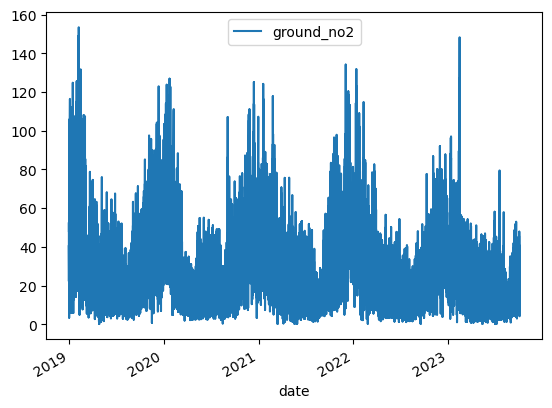

In [11]:
milano_no2[["date", "ground_no2"]].plot(x="date", y="ground_no2")

In [12]:
milano_no2.set_index("date", inplace=True, drop=True)
milano_no2

,idsensore,ground_no2,x,y,geometry
date,,,,,
2019-01-01,5504,48.175,9.190934,45.496316,POINT (9.19093 45.49632)
2019-01-01,5507,52.550,9.236108,45.534766,POINT (9.23611 45.53477)
2019-01-01,5517,30.525,9.044600,45.523426,POINT (9.04460 45.52343)
2019-01-01,5520,22.250,8.736497,45.526551,POINT (8.73650 45.52655)
2019-01-01,5531,34.775,9.195325,45.463347,POINT (9.19532 45.46335)
...,...,...,...,...,...
2023-10-05,5551,30.775,9.197460,45.470499,POINT (9.19746 45.47050)
2023-10-05,5554,17.450,8.847322,45.548517,POINT (8.84732 45.54852)
2023-10-05,5609,28.075,9.282700,45.396195,POINT (9.28270 45.39619)


# ERA5 Meteo Data

In [13]:
# Specify the directory containing the .nc files
directory_path = "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/ERA5/boundary_layer/MCM"

# Construct the glob pattern for all .nc files in the directory
nc_files_pattern = os.path.join(directory_path, "*.nc")

# Use glob to list all files matching the pattern
nc_files = glob.glob(nc_files_pattern)

# Check if there are any .nc files to process
if nc_files:
    # Use xarray to open and combine the .nc files
    # The combine_by_coords function automatically combines files along the time dimension
    combined_ds = xr.open_mfdataset(nc_files, combine="by_coords")
else:
    print("No .nc files found in the specified directory.")

In [14]:
df_era5 = combined_ds.to_dataframe()
df_era5 = df_era5.reset_index()
df_era5["date"] = df_era5["time"].dt.strftime("%Y-%m-%d")
df_era5["date"] = pd.to_datetime(df_era5["date"], format="%Y-%m-%d")
df_era5 = df_era5.rename(
    columns={
        "t2m": "surface_temperature",
        "ssr": "surface_net_solar_radiation",
        "str": "surface_net_thermal_radiation",
        "sp": "surface_pressure",
        "tp": "total_precipitation",
        "blh": "boundary_layer_height",
    }
)

# df_era5["latitude"] = np.round(df_era5["latitude"])
# df_era5["longitude"] = np.round(df_era5["longitude"])

print(f"\rDropping null values...                ", end="")
df_era5.dropna(inplace=True, axis=0)

print(f"\rTransforming temperature to celsius...                ", end="")
df_era5["temp_celsius"] = df_era5["surface_temperature"] - 273.15

print(f"\rCreating geometry column......                ", end="")
df_era5 = gpd.GeoDataFrame(
    df_era5, geometry=gpd.points_from_xy(df_era5["longitude"], df_era5["latitude"])
)
print(f"\rApplying CRS definition...                ", end="")
df_era5.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

df_era5 = gpd.clip(df_era5, milano.geometry)
df_era5.set_index("time", drop=True, inplace=True)
print(f"\rCOMPLETE                                                ", end="")

COMPLETE                                                

### Current day dataframe (between 10:00 and 13:00)

In [15]:
curr_df_era5 = df_era5.between_time("13:00", "15:00")
curr_df_era5 = curr_df_era5.add_prefix("curr_")
curr_df_era5.rename(columns={"curr_date": "date"}, inplace=True)
# curr_df_era5.drop(["curr_time"], axis=1, inplace=True)
curr_df_era5.sort_index(inplace=True)
curr_df_era5.reset_index(drop=False, inplace=True)
curr_df_era5.rename(
    columns={"curr_latitude": "latitude", "curr_longitude": "longitude"}, inplace=True
)

### Previous day dataframe

In [16]:
prev_1_df_era5 = df_era5.between_time("00:00", "12:59")
prev_2_df_era5 = df_era5.between_time("14:01", "23:59")
prev_2_df_era5 = prev_2_df_era5.shift(1, freq="D")

prev_df_era5 = pd.concat([prev_1_df_era5, prev_2_df_era5])
del df_era5
del prev_1_df_era5
del prev_2_df_era5
prev_df_era5 = prev_df_era5.add_prefix("prev_")
# prev_df_era5.set_index("prev_date", drop=True, inplace=True)
# prev_df_era5.reset_index(drop=False, inplace=True)
prev_df_era5.rename(
    columns={
        "prev_latitude": "latitude",
        "prev_longitude": "longitude",
        "prev_date": "date",
    },
    inplace=True,
)
# prev_df_era5.drop(["prev_time"], axis=1, inplace=True)
prev_df_era5.sort_index(inplace=True)
prev_df_era5.reset_index(drop=False, inplace=True)

### Combination of current and previous dataframes

In [17]:
# curr_df_era5.rename(columns={"time": "date"}, inplace=True)
# prev_df_era5.rename(columns={"time": "date"}, inplace=True)

curr_df_era5["date"] = pd.to_datetime(curr_df_era5["date"], format="%Y-%m-%d")
prev_df_era5["date"] = pd.to_datetime(prev_df_era5["date"], format="%Y-%m-%d")

curr_df_era5["date"] = curr_df_era5["date"].dt.date
prev_df_era5["date"] = prev_df_era5["date"].dt.date

curr_df_era5 = curr_df_era5.groupby(
    ["date", "latitude", "longitude", "curr_geometry"]
).mean()
prev_df_era5 = prev_df_era5.groupby(
    ["date", "latitude", "longitude", "prev_geometry"]
).mean()

complete_gdf_era5 = curr_df_era5.merge(
    prev_df_era5,
    how="left",
    left_on=["date", "latitude", "longitude"],
    right_on=["date", "latitude", "longitude"],
)
del curr_df_era5
del prev_df_era5
complete_gdf_era5.reset_index(inplace=True, drop=False)
complete_gdf_era5.rename(columns={"latitude": "lat", "longitude": "lng"}, inplace=True)

In [18]:
complete_gdf_era5.set_index(["date"], inplace=True, drop=True)
complete_gdf_era5["curr_wind_dir"] = np.rad2deg(
    np.arctan2(complete_gdf_era5["curr_v10"], complete_gdf_era5["curr_u10"])
)
complete_gdf_era5["curr_wind_speed"] = np.sqrt(
    complete_gdf_era5["curr_v10"] ** 2 + complete_gdf_era5["curr_u10"] ** 2
)
complete_gdf_era5["curr_wind_dir"] = np.where(
    complete_gdf_era5["curr_wind_dir"] < 0,
    complete_gdf_era5["curr_wind_dir"] + 360,
    complete_gdf_era5["curr_wind_dir"],
)

complete_gdf_era5["prev_wind_dir"] = np.rad2deg(
    np.arctan2(complete_gdf_era5["prev_v10"], complete_gdf_era5["prev_u10"])
)
complete_gdf_era5["prev_wind_speed"] = np.sqrt(
    complete_gdf_era5["prev_v10"] ** 2 + complete_gdf_era5["prev_u10"] ** 2
)
complete_gdf_era5["prev_wind_dir"] = np.where(
    complete_gdf_era5["prev_wind_dir"] < 0,
    complete_gdf_era5["prev_wind_dir"] + 360,
    complete_gdf_era5["prev_wind_dir"],
)

complete_gdf_era5 = complete_gdf_era5[
    [
        "lat",
        "lng",
        "curr_temp_celsius",
        "curr_surface_net_solar_radiation",
        "curr_surface_net_thermal_radiation",
        "curr_surface_pressure",
        "curr_total_precipitation",
        "curr_wind_dir",
        "curr_wind_speed",
        "curr_boundary_layer_height",
        "prev_temp_celsius",
        "prev_surface_net_solar_radiation",
        "prev_surface_net_thermal_radiation",
        "prev_surface_pressure",
        "prev_total_precipitation",
        "prev_wind_dir",
        "prev_wind_speed",
        "prev_boundary_layer_height",
    ]
]

complete_gdf_era5.to_csv("/Volumes/Rodrigo_2TB/CDMX/Dataframes/df-era5-milano.csv")
complete_gdf_era5

,lat,lng,curr_temp_celsius,curr_surface_net_solar_radiation,curr_surface_net_thermal_radiation,curr_surface_pressure,curr_total_precipitation,curr_wind_dir,curr_wind_speed,curr_boundary_layer_height,prev_temp_celsius,prev_surface_net_solar_radiation,prev_surface_net_thermal_radiation,prev_surface_pressure,prev_total_precipitation,prev_wind_dir,prev_wind_speed,prev_boundary_layer_height
date,,,,,,,,,,,,,,,,,,
2019-01-01,45.5,8.75,6.760899,659590.937500,-328683.718750,100185.257812,0.000000,88.360710,0.217189,250.184814,2.931659,141611.125000,-211045.765625,100261.632812,0.000000e+00,261.346375,0.637967,76.735786
2019-01-01,45.5,9.00,6.808171,653299.562500,-321276.125000,100291.632812,0.000000,353.303711,0.724662,309.881439,3.073473,141966.687500,-215278.500000,100370.320312,0.000000e+00,295.368652,0.915699,91.453026
2019-01-01,45.5,9.25,6.665063,650464.687500,-321753.531250,101010.000000,0.000000,11.295276,1.120976,341.784943,3.141687,144222.062500,-224331.406250,101084.281250,0.000000e+00,307.166443,0.618917,98.192207
2019-01-01,45.5,9.50,6.389530,651677.437500,-333052.500000,100403.031250,0.000000,16.906410,1.331963,356.766724,2.668072,149954.562500,-236176.000000,100480.929688,0.000000e+00,309.702179,0.557869,93.771004
2019-01-02,45.5,8.75,10.001937,770652.187500,-429650.656250,99752.789062,0.000000,233.104553,6.924938,1086.225586,5.215714,183938.187500,-298648.906250,99697.125000,4.741279e-08,259.530273,3.997166,600.390808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30,45.5,9.50,9.927871,506879.906250,-266188.968750,99868.054688,0.000000,103.812225,0.809729,349.693329,7.906922,125769.000000,-143429.484375,99912.843750,6.689648e-07,249.209778,0.344952,74.828072
2023-12-31,45.5,8.75,7.210769,60368.250000,-23313.896484,98826.445312,0.001152,240.212051,2.199970,196.452927,6.850798,16400.550781,-39333.839844,99104.382812,2.742242e-04,255.421936,1.342347,93.487640
2023-12-31,45.5,9.00,7.060042,59617.042969,-23091.427734,98946.226562,0.001233,235.327972,2.122506,216.478226,7.191257,14900.846680,-30395.857422,99219.679688,3.337267e-04,244.758331,0.989269,114.170677


<Axes: xlabel='date'>

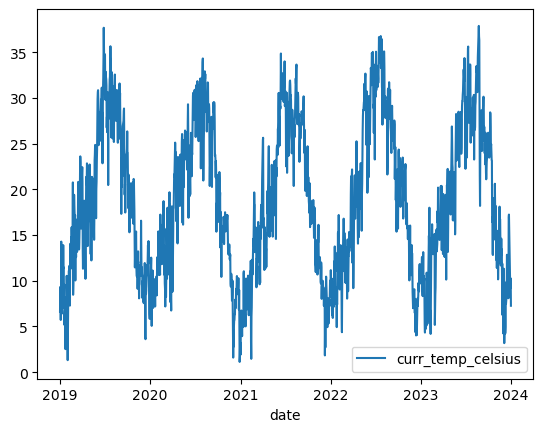

In [19]:
complete_gdf_era5.reset_index(drop=False)[["date", "curr_temp_celsius"]].groupby(
    "date"
).mean().plot()

# Create table with nearest points

In [20]:
S5P_gdf.drop(columns=["geometry"])
S5P_gdf["lat"] = S5P_gdf["geometry"].y
S5P_gdf["lng"] = S5P_gdf["geometry"].x

complete_gdf_era5 = gpd.GeoDataFrame(
    complete_gdf_era5,
    geometry=gpd.points_from_xy(complete_gdf_era5["lng"], complete_gdf_era5["lat"]),
)

S5P_gdf.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
milano_no2.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
complete_gdf_era5.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

S5P_gdf = S5P_gdf.to_crs(epsg=3857)
milano_no2 = milano_no2.to_crs(epsg=3857)
complete_gdf_era5 = complete_gdf_era5.to_crs(epsg=3857)

S5P_gdf.reset_index(drop=False, inplace=True)
S5P_gdf["date"] = S5P_gdf["date"].dt.date
S5P_gdf = S5P_gdf.groupby(["date", "geometry"]).mean()

milano_no2.reset_index(drop=False, inplace=True)
milano_no2["date"] = milano_no2["date"].dt.date
milano_no2 = milano_no2.groupby(["date", "idsensore", "geometry"]).mean()

complete_gdf_era5.reset_index(drop=False, inplace=True)
complete_gdf_era5 = complete_gdf_era5.groupby(["date", "geometry"]).mean()
S5P_gdf.reset_index(drop=False, inplace=True)
S5P_gdf.drop(columns=["index"])
milano_no2.reset_index(drop=False, inplace=True)
complete_gdf_era5.reset_index(drop=False, inplace=True)

In [21]:
unique_stations = milano_no2[["idsensore", "geometry"]]
unique_stations = unique_stations.groupby(["idsensore", "geometry"]).mean()
unique_stations.reset_index(inplace=True, drop=False)
unique_stations = gpd.GeoDataFrame(unique_stations)
unique_stations = unique_stations.set_crs(epsg=3857)

unique_stations["sat_nearest_point"] = "nan"
unique_stations["gr_sat_distance"] = np.nan
unique_stations["era5_nearest_point"] = "nan"
unique_stations["gr_era5_distance"] = np.nan

for no2_ind in range(0, len(unique_stations)):
    no2_point = unique_stations["geometry"][no2_ind]
    min_points_dist_sat = 9e50
    min_points_dist_era5 = 9e500

    for sat_point in S5P_gdf["geometry"].unique():
        dist_points_sat = no2_point.distance(sat_point)
        if dist_points_sat < min_points_dist_sat:
            min_points_dist_sat = dist_points_sat
            closest_sat_point = sat_point

    for era5_point in complete_gdf_era5["geometry"].unique():
        dist_points_era5 = no2_point.distance(era5_point)
        if dist_points_era5 < min_points_dist_era5:
            min_points_dist_era5 = dist_points_era5
            closest_era5_point = era5_point

    unique_stations.loc[no2_ind, "sat_nearest_point"] = closest_sat_point
    unique_stations.loc[no2_ind, "gr_sat_distance"] = min_points_dist_sat

    unique_stations.loc[no2_ind, "era5_nearest_point"] = closest_era5_point
    unique_stations.loc[no2_ind, "gr_era5_distance"] = min_points_dist_era5

In [22]:
S5P_gdf_merge = S5P_gdf.merge(
    unique_stations[["idsensore", "sat_nearest_point"]],
    left_on="geometry",
    right_on="sat_nearest_point",
    suffixes=("", "drop"),
)
S5P_gdf_merge = S5P_gdf_merge[
    [col for col in S5P_gdf_merge.columns if not col.endswith("_drop")]
]

complete_gdf_era5_merge = complete_gdf_era5.merge(
    unique_stations[["idsensore", "era5_nearest_point"]],
    left_on="geometry",
    right_on="era5_nearest_point",
    suffixes=("", "drop"),
)

complete_gdf_era5_merge = complete_gdf_era5_merge[
    [col for col in complete_gdf_era5_merge.columns if not col.endswith("_drop")]
]

S5P_gdf_merge = S5P_gdf_merge[["date", "geometry", "idsensore", "satellite_no2"]]
complete_gdf_era5_merge = complete_gdf_era5_merge[
    [
        "date",
        "geometry",
        "idsensore",
        "curr_temp_celsius",
        "curr_surface_net_solar_radiation",
        "curr_surface_net_thermal_radiation",
        "curr_surface_pressure",
        "curr_total_precipitation",
        "curr_wind_dir",
        "curr_wind_speed",
        "curr_boundary_layer_height",
        "prev_temp_celsius",
        "prev_surface_net_solar_radiation",
        "prev_surface_net_thermal_radiation",
        "prev_surface_pressure",
        "prev_total_precipitation",
        "prev_wind_dir",
        "prev_wind_speed",
        "prev_boundary_layer_height",
    ]
]
S5P_gdf_merge.dropna(axis=0, inplace=True)
complete_gdf_era5_merge.dropna(axis=0, inplace=True)

In [23]:
milano_df_complete = milano_no2.merge(
    S5P_gdf_merge,
    left_on=["date", "idsensore"],
    right_on=["date", "idsensore"],
    suffixes=("", "_drop"),
)
del milano_no2
milano_df_complete = milano_df_complete[
    [col for col in milano_df_complete.columns if not col.endswith("_drop")]
]
milano_df_complete = milano_df_complete.merge(
    complete_gdf_era5_merge,
    left_on=["date", "idsensore"],
    right_on=["date", "idsensore"],
    suffixes=("", "_drop"),
)

del complete_gdf_era5_merge

milano_df_complete = milano_df_complete[
    [col for col in milano_df_complete.columns if not col.endswith("_drop")]
]
# milano_df_complete.drop(columns=["x", "y"], inplace=True)
milano_df_complete.dropna(axis=0, inplace=True)
milano_df_complete.set_index("date", inplace=True)
milano_df_complete.drop(columns=["x", "y"], inplace=True)

# Elevation

elev_xr_1 = rio.open_rasterio(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/Elevation/n45_e008_1arc_v3.tif"
)
elev_xr_2 = rio.open_rasterio(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/Elevation/n45_e009_1arc_v3.tif"
)

In [24]:
elev_xr_3 = rio.open_rasterio(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/DEM/MCM_GMTED2010N30E000_075/30n000e_20101117_gmted_mea075.tif"
)
elev_pd = elev_xr_3[0].to_pandas()
del elev_xr_3
elev_pd = elev_pd.melt(ignore_index=False)
elev_pd = elev_pd.reset_index(drop=False)

In [25]:
print("Reducing area size...")
elev_pd = elev_pd[
    (elev_pd["y"] >= milano.bounds["miny"][0])
    & (elev_pd["y"] <= milano.bounds["maxy"][0])
    & (elev_pd["x"] >= milano.bounds["minx"][0])
    & (elev_pd["x"] <= milano.bounds["maxx"][0])
]
elev_pd.reset_index(drop=True, inplace=True)

Reducing area size...


In [26]:
print("Transofrming to Geopandas…")
elev_gpd = gpd.GeoDataFrame(
    elev_pd, geometry=gpd.points_from_xy(elev_pd["x"], elev_pd["y"])
)
del elev_pd
print("Defining CRS…")
elev_gpd.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
# print("Changing CRS to EPSG:3857…")
# elev_gpd = elev_gpd.to_crs(epsg=3857)
print("COMPLETE")

Transofrming to Geopandas…
Defining CRS…
COMPLETE


In [27]:
elev_gpd = elev_gpd[["value", "geometry"]]
elev_gpd.rename(columns={"value": "elevation"})
elev_gpd.reset_index(inplace=True, drop=True)
elev_gpd

,value,geometry
0,237,POINT (8.70715 45.64257)
1,237,POINT (8.70715 45.64049)
2,236,POINT (8.70715 45.63840)
3,232,POINT (8.70715 45.63632)
4,230,POINT (8.70715 45.63424)
...,...,...
73887,73,POINT (9.55090 45.27382)
73888,70,POINT (9.55090 45.27174)
73889,70,POINT (9.55090 45.26965)
73890,69,POINT (9.55090 45.26757)


In [28]:
print("Clipping to MCM…")
elev_gpd = gpd.clip(elev_gpd, milano.geometry[0])
print("Changing CRS to EPSG:3857…")
elev_gpd = elev_gpd.to_crs(epsg=3857)
print("COMPLETE!")
elev_gpd

Clipping to MCM…
Changing CRS to EPSG:3857…
COMPLETE!


,value,geometry
24387,72,POINT (1000120.589 5663414.123)
24568,67,POINT (1000352.505 5663743.638)
24386,70,POINT (1000120.589 5663743.638)
24750,72,POINT (1000584.420 5663743.638)
24204,74,POINT (999888.673 5663743.638)
...,...,...
20386,243,POINT (995250.361 5722591.157)
20568,240,POINT (995482.277 5722591.157)
20022,246,POINT (994786.530 5722591.157)
20203,228,POINT (995018.446 5722922.858)


In [29]:
unique_stations["elev_nearest_point"] = "nan"
unique_stations["gr_elev_distance"] = np.nan
for no2_ind in range(0, len(unique_stations)):
    no2_point = unique_stations["geometry"][no2_ind]
    min_points_dist = 9e20
    for elev_point in elev_gpd["geometry"].unique():
        dist_points = no2_point.distance(elev_point)
        if dist_points < min_points_dist:
            min_points_dist = dist_points
            closest_elev_point = elev_point
    unique_stations.loc[no2_ind, "elev_nearest_point"] = closest_elev_point
    unique_stations.loc[no2_ind, "gr_elev_distance"] = min_points_dist

unique_stations

,idsensore,geometry,sat_nearest_point,gr_sat_distance,era5_nearest_point,gr_era5_distance,elev_nearest_point,gr_elev_distance
0,5504,POINT (1023130.043 5699997.723),POINT (1021356.3280282851 5700582.732404124),1867.699475,POINT (1029705.2898377805 5700582.732404124),6601.219783,POINT (1023080.234031542 5700064.371558823),83.204174
1,5507,POINT (1028158.831 5706105.991),POINT (1026922.3025679489 5706937.852318865),1490.300775,POINT (1029705.2898377805 5700582.732404124),5735.670480,POINT (1028182.377359567 5706021.81851389),87.403481
2,5517,POINT (1006840.252 5704304.006),POINT (1004658.4044092939 5706937.852318865),3420.175905,POINT (1001875.4171394621 5700582.732404124),6204.632678,POINT (1006846.1416241896 5704366.573859952),62.843974
3,5520,POINT (972542.350 5704800.577),POINT (971262.5571713118 5706937.852318865),2491.147428,POINT (974045.5444411436 5700582.732404124),4477.701125,POINT (972522.6319629301 5704697.5982687995),104.849832
4,5531,POINT (1023618.875 5694763.299),POINT (1021356.3280282851 5694232.12571674),2324.062142,POINT (1029705.2898377805 5700582.732404124),8420.822407,POINT (1023544.0652431806 5694772.192897401),75.336878
5,5532,POINT (1027230.016 5708897.060),POINT (1026922.3025679489 5706937.852318865),1983.225023,POINT (1029705.2898377805 5700582.732404124),8674.965332,POINT (1027254.7149362896 5709002.031699727),107.838512
6,5534,POINT (1038316.969 5697983.258),POINT (1038054.2516472762 5700582.732404124),2612.716875,POINT (1029705.2898377805 5700582.732404124),8995.459565,POINT (1038386.664015617 5698079.437632035),118.776816
7,5542,POINT (1020570.914 5691670.559),POINT (1021356.3280282851 5694232.12571674),2679.271879,POINT (1029705.2898377805 5700582.732404124),12761.804630,POINT (1020529.1623675294 5691796.717427682),132.887189
8,5547,POINT (1019977.486 5708692.971),POINT (1021356.3280282851 5706937.852318865),2231.959813,POINT (1029705.2898377805 5700582.732404124),12665.153987,POINT (1020065.3311558908 5708670.847810731),90.587797
9,5548,POINT (1000602.226 5666019.477),POINT (999092.4298696303 5668874.641676818),3229.774966,POINT (1001875.4171394621 5700582.732404124),34586.697016,POINT (1000584.420267068 5666050.578467279),35.837244


In [30]:
elev_nearest_point = list(unique_stations["elev_nearest_point"].values)
gdf_elev_milano = elev_gpd[elev_gpd["geometry"].isin(elev_nearest_point)]

gdf_elev_milano["id"] = 0
for point in gdf_elev_milano["geometry"].unique():
    id_st = unique_stations["idsensore"][
        unique_stations["gr_elev_distance"]
        == (
            unique_stations[(unique_stations["elev_nearest_point"] == point)][
                "gr_elev_distance"
            ].min()
        )
    ].values[0]
    gdf_elev_milano.loc[gdf_elev_milano["geometry"] == point, "id"] = id_st

gdf_elev_milano = gdf_elev_milano[["value", "id"]]
gdf_elev_milano.rename(columns={"value": "elevation"}, inplace=True)

In [31]:
gdf_elev_milano.rename(columns={"value": "elevation"}, inplace=True)

In [32]:
gdf_elev_milano

,elevation,id
24743,94,5548
50350,100,5609
54312,120,5534
70672,133,9999
40317,116,5542
42674,128,5531
42853,130,5551
29541,153,5517
46307,118,10279
42294,133,5504


# Land Use

In [33]:
# Function to read a TIFF file and convert it to a pandas DataFrame
def tiff_to_dataframe(tiff_path):
    with rasterio.open(tiff_path) as src:
        band = src.read(1)  # Read the first band

        # Get the coordinates
        rows, cols = np.meshgrid(
            np.arange(band.shape[0]), np.arange(band.shape[1]), indexing="ij"
        )
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)

        # Flatten the arrays and create a DataFrame
        data = {
            "x": np.array(xs).flatten(),
            "y": np.array(ys).flatten(),
            "value": band.flatten(),
        }
        df = pd.DataFrame(data)
    return df

In [34]:
tiff_path = "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/LU/globalIntraUrbanLanduse_MCM.tif"
land_use = tiff_to_dataframe(tiff_path)

print("Transofrming to Geopandas…")
land_use = gpd.GeoDataFrame(
    land_use, geometry=gpd.points_from_xy(land_use["x"], land_use["y"])
)

print("Defining CRS…")
land_use.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
print("Changing CRS to EPSG:3857…")
lu_gpd = land_use.to_crs(epsg=3857)
print("COMPLETE")

Transofrming to Geopandas…
Defining CRS…
Changing CRS to EPSG:3857…
COMPLETE


In [35]:
lu_gpd

,x,y,value,geometry
0,8.601593,45.886169,0,POINT (957525.000 5762126.496)
1,8.602043,45.886169,0,POINT (957575.000 5762126.496)
2,8.602492,45.886169,0,POINT (957625.000 5762126.496)
3,8.602941,45.886169,0,POINT (957675.000 5762126.496)
4,8.603390,45.886169,2,POINT (957725.000 5762126.496)
...,...,...,...,...
5111615,10.351961,45.298222,0,POINT (1152375.000 5668593.249)
5111616,10.352410,45.298222,0,POINT (1152425.000 5668593.249)
5111617,10.352859,45.298222,0,POINT (1152475.000 5668593.249)
5111618,10.353308,45.298222,0,POINT (1152525.000 5668593.249)


In [36]:
unique_stations["lu_nearest_point"] = "nan"
unique_stations["gr_lu_distance"] = np.nan
for no2_ind in range(0, len(unique_stations)):
    no2_point = unique_stations["geometry"][no2_ind]
    min_points_dist = 9e20
    for lu_point in lu_gpd["geometry"].unique():
        dist_points = no2_point.distance(lu_point)
        if dist_points < min_points_dist:
            min_points_dist = dist_points
            closest_lu_point = lu_point
    unique_stations.loc[no2_ind, "lu_nearest_point"] = closest_lu_point
    unique_stations.loc[no2_ind, "gr_lu_distance"] = min_points_dist

unique_stations

,idsensore,geometry,sat_nearest_point,gr_sat_distance,era5_nearest_point,gr_era5_distance,elev_nearest_point,gr_elev_distance,lu_nearest_point,gr_lu_distance
0,5504,POINT (1023130.043 5699997.723),POINT (1021356.3280282851 5700582.732404124),1867.699475,POINT (1029705.2898377805 5700582.732404124),6601.219783,POINT (1023080.234031542 5700064.371558823),83.204174,POINT (1023125.0000000001 5699995.184791474),5.646195
1,5507,POINT (1028158.831 5706105.991),POINT (1026922.3025679489 5706937.852318865),1490.300775,POINT (1029705.2898377805 5700582.732404124),5735.670480,POINT (1028182.377359567 5706021.81851389),87.403481,POINT (1028175.0000000002 5706131.775400628),30.435109
2,5517,POINT (1006840.252 5704304.006),POINT (1004658.4044092939 5706937.852318865),3420.175905,POINT (1001875.4171394621 5700582.732404124),6204.632678,POINT (1006846.1416241896 5704366.573859952),62.843974,POINT (1006825.0000000002 5704276.082778562),31.817582
3,5520,POINT (972542.350 5704800.577),POINT (971262.5571713118 5706937.852318865),2491.147428,POINT (974045.5444411436 5700582.732404124),4477.701125,POINT (972522.6319629301 5704697.5982687995),104.849832,POINT (972525.0000000001 5704775.654431351),30.367479
4,5531,POINT (1023618.875 5694763.299),POINT (1021356.3280282851 5694232.12571674),2324.062142,POINT (1029705.2898377805 5700582.732404124),8420.822407,POINT (1023544.0652431806 5694772.192897401),75.336878,POINT (1023625.0000000002 5694789.520629995),26.927639
5,5532,POINT (1027230.016 5708897.060),POINT (1026922.3025679489 5706937.852318865),1983.225023,POINT (1029705.2898377805 5700582.732404124),8674.965332,POINT (1027254.7149362896 5709002.031699727),107.838512,POINT (1027225.0000000001 5708916.037030841),19.628792
6,5534,POINT (1038316.969 5697983.258),POINT (1038054.2516472762 5700582.732404124),2612.716875,POINT (1029705.2898377805 5700582.732404124),8995.459565,POINT (1038386.664015617 5698079.437632035),118.776816,POINT (1038325.0000000001 5697998.133530397),16.905105
7,5542,POINT (1020570.914 5691670.559),POINT (1021356.3280282851 5694232.12571674),2679.271879,POINT (1029705.2898377805 5700582.732404124),12761.804630,POINT (1020529.1623675294 5691796.717427682),132.887189,POINT (1020575.0000000001 5691653.32234475),17.714845
8,5547,POINT (1019977.486 5708692.971),POINT (1021356.3280282851 5706937.852318865),2231.959813,POINT (1029705.2898377805 5700582.732404124),12665.153987,POINT (1020065.3311558908 5708670.847810731),90.587797,POINT (1019975.0000000003 5708701.832254761),9.203907
9,5548,POINT (1000602.226 5666019.477),POINT (999092.4298696303 5668874.641676818),3229.774966,POINT (1001875.4171394621 5700582.732404124),34586.697016,POINT (1000584.420267068 5666050.578467279),35.837244,POINT (1000625.0000000002 5668593.249407247),2573.872731


In [37]:
lu_nearest_point = list(unique_stations["lu_nearest_point"].values)
gdf_lu_milano = lu_gpd[lu_gpd["geometry"].isin(lu_nearest_point)]

gdf_lu_milano["id"] = 0
for point in gdf_lu_milano["geometry"].unique():
    id_st = unique_stations["idsensore"][
        unique_stations["gr_lu_distance"]
        == (
            unique_stations[(unique_stations["lu_nearest_point"] == point)][
                "gr_lu_distance"
            ].min()
        )
    ].values[0]
    gdf_lu_milano.loc[gdf_lu_milano["geometry"] == point, "id"] = id_st

gdf_lu_milano = gdf_lu_milano[["value", "id"]]
gdf_lu_milano.rename(columns={"value": "landUse"}, inplace=True)

In [38]:
gdf_lu_milano

,landUse,id
2900580,1,5532
2912141,1,5547
2934851,0,5554
3052777,4,5507
3125802,0,5520
3127538,4,9999
3153802,1,5517
3388248,4,5504
3497808,4,5534
3540525,1,10279


# Merge Dataframes

In [39]:
milano_df_complete.reset_index(drop=False, inplace=True)

In [40]:
milano_df_complete = milano_df_complete.merge(
    gdf_elev_milano,
    how="left",
    left_on=["idsensore"],
    right_on=["id"],
    suffixes=("", "_drop"),
)

milano_df_complete = milano_df_complete.merge(
    gdf_lu_milano,
    how="left",
    left_on=["idsensore"],
    right_on=["id"],
    suffixes=("", "_drop"),
)

milano_df_complete.drop(columns=["id_drop"], inplace=True)

In [50]:
milano_df_complete

,date,idsensore,geometry,ground_no2,satellite_no2,curr_temp_celsius,curr_surface_net_solar_radiation,curr_surface_net_thermal_radiation,curr_surface_pressure,curr_total_precipitation,...,prev_surface_net_solar_radiation,prev_surface_net_thermal_radiation,prev_surface_pressure,prev_total_precipitation,prev_wind_dir,prev_wind_speed,prev_boundary_layer_height,elevation,id,landUse
0,2019-01-01,5504,POINT (1023130.043 5699997.723),48.175,0.000177,6.665063,6.504647e+05,-321753.53125,101010.000000,0.0,...,144222.0625,-224331.406250,101084.281250,0.000000e+00,307.166443,0.618917,98.192207,133,5504,4
1,2019-01-01,5507,POINT (1028158.831 5706105.991),52.550,0.000206,6.665063,6.504647e+05,-321753.53125,101010.000000,0.0,...,144222.0625,-224331.406250,101084.281250,0.000000e+00,307.166443,0.618917,98.192207,147,5507,4
2,2019-01-01,5517,POINT (1006840.252 5704304.006),30.525,0.000167,6.808171,6.532996e+05,-321276.12500,100291.632812,0.0,...,141966.6875,-215278.500000,100370.320312,0.000000e+00,295.368652,0.915699,91.453026,153,5517,1
3,2019-01-01,5520,POINT (972542.350 5704800.577),22.250,0.000132,6.760899,6.595909e+05,-328683.71875,100185.257812,0.0,...,141611.1250,-211045.765625,100261.632812,0.000000e+00,261.346375,0.637967,76.735786,142,5520,0
4,2019-01-01,5531,POINT (1023618.875 5694763.299),34.775,0.000177,6.665063,6.504647e+05,-321753.53125,101010.000000,0.0,...,144222.0625,-224331.406250,101084.281250,0.000000e+00,307.166443,0.618917,98.192207,128,5531,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14031,2023-10-05,5551,POINT (1023856.604 5695898.567),30.775,0.000199,24.132562,1.211301e+06,-303989.71875,100683.882812,0.0,...,340119.4375,-182725.109375,100803.953125,1.965662e-06,196.399277,1.020144,277.026550,130,5551,1
14032,2023-10-05,5554,POINT (984879.372 5708291.657),17.450,0.000095,23.806299,1.177316e+06,-291327.87500,99891.804688,0.0,...,323475.0625,-172172.109375,100010.695312,4.672191e-06,233.137573,1.181950,281.291656,183,5554,0
14033,2023-10-05,5609,POINT (1033345.446 5684111.373),28.075,0.000133,24.132562,1.211301e+06,-303989.71875,100683.882812,0.0,...,340119.4375,-182725.109375,100803.953125,1.965662e-06,196.399277,1.020144,277.026550,100,5609,4
14034,2023-10-05,9999,POINT (1059314.102 5704788.132),27.525,0.000105,23.749363,1.164335e+06,-301629.28125,100120.976562,0.0,...,352401.9375,-188918.406250,100239.500000,7.718759e-07,189.758072,0.753798,257.966614,133,9999,4


In [47]:
milano_df_corr

,ground_no2,satellite_no2,curr_temp_celsius,curr_surface_net_solar_radiation,curr_surface_net_thermal_radiation,curr_surface_pressure,curr_total_precipitation,curr_wind_dir,curr_wind_speed,curr_boundary_layer_height,...,prev_surface_net_solar_radiation,prev_surface_net_thermal_radiation,prev_surface_pressure,prev_total_precipitation,prev_wind_dir,prev_wind_speed,prev_boundary_layer_height,elevation,id,landUse
0,48.175,0.000177,6.665063,6.504647e+05,-321753.53125,101010.000000,0.0,11.295276,1.120976,341.784943,...,144222.0625,-224331.406250,101084.281250,0.000000e+00,307.166443,0.618917,98.192207,133,5504,4
1,52.550,0.000206,6.665063,6.504647e+05,-321753.53125,101010.000000,0.0,11.295276,1.120976,341.784943,...,144222.0625,-224331.406250,101084.281250,0.000000e+00,307.166443,0.618917,98.192207,147,5507,4
2,30.525,0.000167,6.808171,6.532996e+05,-321276.12500,100291.632812,0.0,353.303711,0.724662,309.881439,...,141966.6875,-215278.500000,100370.320312,0.000000e+00,295.368652,0.915699,91.453026,153,5517,1
3,22.250,0.000132,6.760899,6.595909e+05,-328683.71875,100185.257812,0.0,88.360710,0.217189,250.184814,...,141611.1250,-211045.765625,100261.632812,0.000000e+00,261.346375,0.637967,76.735786,142,5520,0
4,34.775,0.000177,6.665063,6.504647e+05,-321753.53125,101010.000000,0.0,11.295276,1.120976,341.784943,...,144222.0625,-224331.406250,101084.281250,0.000000e+00,307.166443,0.618917,98.192207,128,5531,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14031,30.775,0.000199,24.132562,1.211301e+06,-303989.71875,100683.882812,0.0,64.886162,0.863237,895.968201,...,340119.4375,-182725.109375,100803.953125,1.965662e-06,196.399277,1.020144,277.026550,130,5551,1
14032,17.450,0.000095,23.806299,1.177316e+06,-291327.87500,99891.804688,0.0,118.798691,0.547598,952.088318,...,323475.0625,-172172.109375,100010.695312,4.672191e-06,233.137573,1.181950,281.291656,183,5554,0
14033,28.075,0.000133,24.132562,1.211301e+06,-303989.71875,100683.882812,0.0,64.886162,0.863237,895.968201,...,340119.4375,-182725.109375,100803.953125,1.965662e-06,196.399277,1.020144,277.026550,100,5609,4
14034,27.525,0.000105,23.749363,1.164335e+06,-301629.28125,100120.976562,0.0,50.311275,1.216615,878.281189,...,352401.9375,-188918.406250,100239.500000,7.718759e-07,189.758072,0.753798,257.966614,133,9999,4


In [49]:
milano_df_corr = milano_df_complete.drop(columns=["date", "idsensore", "geometry"])
milano_df_corr.corr().iloc[:, 0:1].to_csv("./data/corr_csv.csv")

<Axes: xlabel='date'>

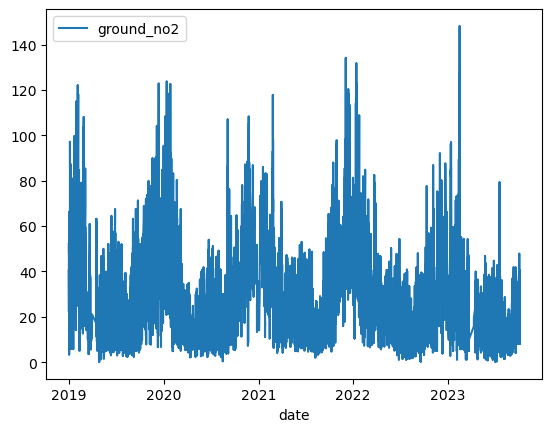

In [41]:
milano_df_complete.plot(x="date", y="ground_no2")

# Export

In [55]:
milano_df_complete.to_csv(
    "/Users/rodrigo/Documents/2_PoliMi/3_Research/Pollution/Prediction/Data/milano-df_complete-2024_06_18.csv"
)